In [1]:
# Import relevant modules

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import math
import random
import numpy as np
import healpy as hp
from scipy.integrate import quad
from scipy.integrate import trapz
from scipy.special import gammaincc
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import *
import pandas as pd
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
from probfit import UnbinnedLH, gaussian, Chi2Regression
from NPTFit import create_mask as cm

import constants
import units

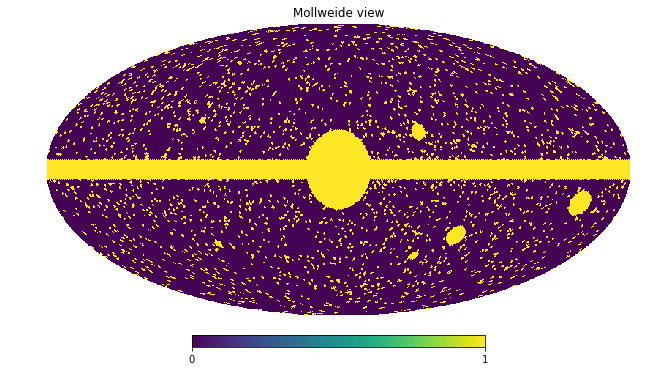

In [344]:
trials = 40
xsec = 1e-24
marr = [100]
channel = 'b'

pscmask=np.array(np.load('fermi_data/fermidata_pscmask.npy'), dtype=bool)
exposure=np.array(np.load('fermi_data/fermidata_exposure.npy'))
mask = cm.make_mask_total(band_mask = True, band_mask_range = 5, mask_ring = True, inner = 20, outer = 180, custom_mask = pscmask)
hp.mollview(mask)

In [3]:
r_s = 199*units.h # scale radius, [kpc/h]
alpha = 0.678
N_calib = 300. # Number of subhalos with masses 10^8 - 10^10 M_sun
M_MW = 1.1e2/units.h # [1e10h M_s]
mMin_calib = 1e-2/units.h # [1e10h M_s]
mMax_calib = 1/units.h # [1e10h M_s]
mMin = 1e-5*M_MW # [1e10h M_s]
mMax = 0.01*M_MW # [1e10 M_s]
c_arr = [37.5153, -1.5093, 1.636 * 10**(-2), 3.66 * 10**(-4), -2.89237 * 10**(-5), 5.32 * 10**(-7)] # constants for SP c-m relation
min_flux =1./(np.sum(exposure[~mask])/len(exposure[~mask]))

The first function I am defining is the subhalo mass function. It is: $\frac{dN}{dm} \propto m^{-1.9}$. It was determined in 0809.0898 (Aquarius).

In [4]:
def dNdm_func(m): # Subhalo mass function, m units [1e10 M_s*h]
    norm = N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9)))
    return norm * (m)**(-1.9)
print(mMin, mMax)
N_subs = round(N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9))) * -.9**(-1) * (mMax**(-.9) - mMin**(-.9))) # Total number of subhalos
print( "My total number of subhalos: " + str(round(N_subs, 2)))
print( "Clumpy's total number of subhalos (x 10^14): 6.1" )

M_subs = quad( lambda m: m*dNdm_func(m), mMin, mMax)[0]
print( "My total subhalo mass fraction: " + str(round(100*M_subs/(M_MW), 3)) + "%")
print( "Clumpy's total subhalo mass fraction: 19%")

0.0015714285714285715 1.5714285714285714
My total number of subhalos: 2218
Clumpy's total number of subhalos (x 10^14): 6.1
My total subhalo mass fraction: 19.906%
Clumpy's total subhalo mass fraction: 19%


Next, I am defining the Einasto distribution and the Sanchez-Prada (SP) concentration-mass relation. The Einasto distribution gives the number density of subhalos as a function of radius. It is defined: $\rho_{Ein}(r) = \rho_{s}exp(-\frac{2}{\alpha}[(\frac{r}{r_s})^{\alpha} - 1 ])$. For subhalos, $\alpha = 0.678$, $r_s = 199 \ kpc$. 0809.0898 (Aquarius) determined that the Einasto profile well-fit subhalos, and gave the quoted parameters. 

The SP concentration-mass relation was found in 1312.1729. It states $c_{200}(M_{200}, z = 0) = \sum_{i=0}^{5} c_i \times [ln(\frac{M_{200}}{h^{-1}M_\odot})]^i$; $c_i = [37.5153, -1.5093, 1.636 \cdot 10^{-2}, 3.66 \cdot 10^{-4}, -2.89237 \cdot 10^{-5}, 5.32 \cdot 10^{-7}]$. I will later use this to calculate the J factors of the subhalos.

In [5]:
rho_s2 = N_subs*units.h / quad(lambda x: 4*np.pi * x**2 * np.exp( -2./alpha * ( (x/r_s)**(alpha) - 1)), 0, constants.r_vir)[0]
def rho_Ein(r): # Einasto density Profile
    return rho_s2 * np.exp( -2./alpha * ( (r/r_s)**(alpha) - 1))

def c200_SP( M200 ): # Sanchez-Conde-Prada mass-concentration relation
    c200_val = 0
    for i in range(6):
        c200_val += c_arr[i] * ( np.log( M200*1e10 ) )**i
    return c200_val

def c200_S( M200, r ):
    alphaR = 0.286
    C1 = 119.75
    C2 = -85.16
    alpha1 = 0.012
    alpha2 = 0.0026
    return (r/units.h/402)**(-alphaR) * ( C1*(M200*1e10*units.h)**(-alpha1) + C2*(M200*1e10*units.h)**(-alpha2))

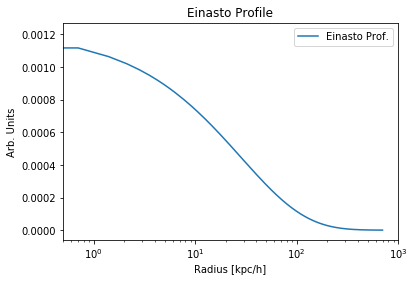

In [311]:
r_test_arr = np.linspace(0*units.h, 1000.5*units.h, 1000)
plt.plot(r_test_arr, rho_Ein(r_test_arr), label="Einasto Prof.")
plt.title("Einasto Profile")
plt.xlabel("Radius [kpc/h]")
plt.ylabel("Arb. Units")
plt.xscale("log")
plt.legend()

(1e-06, 1000000000000.0)

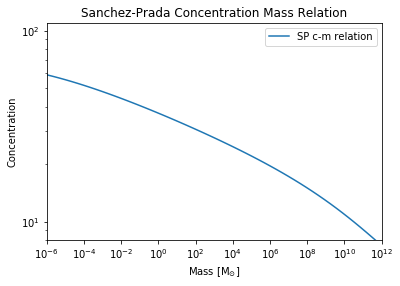

In [312]:
m_test_arr = np.logspace(-20, 12, 100)
plt.plot(m_test_arr*1e10*units.h, c200_SP(m_test_arr), label = "SP c-m relation")
plt.title("Sanchez-Prada Concentration Mass Relation")
plt.xlabel("Mass [M$_{\odot}$]")
plt.ylabel("Concentration")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.ylim(8, 110)
plt.xlim(1e-6, 1e12)

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


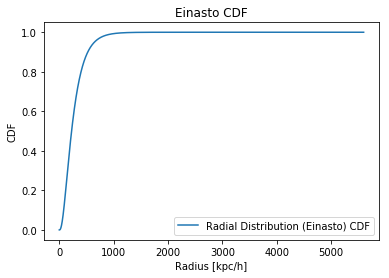

In [8]:
r_arr = np.linspace(0*units.h, 8000*units.h, 8000)
cum_N = np.zeros(len(r_arr))
for ir, r in enumerate(r_arr):
    if 100*ir/len(r_arr) % 10 == 0: print(str(100*ir/len(r_arr)) + "%")
    cum_N[ir] = quad(lambda x: 4*np.pi * x**2 * rho_Ein(x), 0, r)[0]
cum_N = cum_N / max(cum_N)
plt.plot(r_arr, cum_N, label = "Radial Distribution (Einasto) CDF")
plt.xlabel("Radius [kpc/h]")
plt.ylabel("CDF")
plt.title("Einasto CDF")
plt.legend()

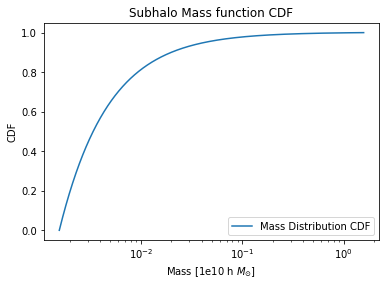

In [9]:
m_arr = np.logspace(np.log10(mMin),np.log10(mMax),1000)
cum_M = m_arr[0]**(-.9) - m_arr**(-.9)
cum_M = cum_M / max(cum_M)
plt.plot(m_arr, cum_M, label = "Mass Distribution CDF")
plt.xscale("log")
plt.xlabel("Mass [1e10 h $M_{\odot}$]")
plt.ylabel("CDF")
plt.title("Subhalo Mass function CDF")
plt.legend()

In [348]:
%%capture output
#Here I am creating subhalos by randomly selecting masses, radii (from the galactic center), and angles on the sphere for N_subs different halos. Doing more than ~1e8 causes memory errors.
F_arr = []
mass_arr_all = []
rval_arr_all = []
with PdfPages('multipage_pdf.pdf') as pdf:
    for trial in tqdm_notebook(range(trials)):
        mass_arr = []
        rval_arr = []
        theta_arr = []
        phi_arr = []
        
        interp_arr = np.linspace(0,1,N_subs)
        mass_arr = ( m_arr[0]**(-.9) - (m_arr[0]**(-.9) - m_arr[-1]**(-.9))*np.random.rand(N_subs))**(-1/.9) #interp_M[np.random.randint(0, N_subs, N_subs)]
        
        interp_N = np.interp(interp_arr, cum_N, r_arr)
        rval_arr = interp_N[np.random.randint(1, N_subs, N_subs)]
        
        theta_arr = (np.pi*np.random.rand(N_subs))
        phi_arr = (2*np.pi*np.random.rand(N_subs))
        
        mass_arr = np.array(mass_arr)
        mass_arr_all.append(mass_arr)
        rval_arr = np.array(rval_arr)
        rval_arr_all.append(rval_arr)
        theta_arr = np.array(theta_arr)
        phi_arr = np.array(phi_arr)
        
        bins = plt.hist(mass_arr, bins=np.logspace(np.log10(mMin),np.log10(mMax), 100), label="Mock Data");
        plt.xlabel("Mass [1e10h $M_{\odot}]$")
        plt.ylabel("Counts")
        plt.xscale("log")
        plt.yscale("log")
        plt.plot(bins[1][:-1], 6 * ( -.9**(-1) * (bins[1][1:]**(-.9) - bins[1][:-1]**(-.9))), label="Theory prediction")
        plt.title("Mock Data Mass Distribution")
        plt.legend()
        pdf.savefig()
        plt.show()
        plt.close()
        
        bins_r = plt.hist(rval_arr, bins = np.linspace(0,2000, 30), label="Mock Data")
        plt.plot(bins_r[1][:-1], 30*4*np.pi*bins_r[1][:-1]**2*rho_Ein(bins_r[1][:-1]), label="Theory Distribution")
        plt.title("Mock Data Radius Distribution")
        plt.ylabel("Counts")
        plt.xlabel("Radius [kpc h$^{-1}$]")
        plt.xlim(0,2000)
        plt.legend()
        pdf.savefig()
        plt.show()
        plt.close()
        
        nside = 128
        mask_ord = []      
        for i in range(N_subs):
            pix = hp.vec2pix(nside, rval_arr[i]*np.cos(phi_arr[i])*np.sin(theta_arr[i]) + constants.r0, rval_arr[i]*np.sin(phi_arr[i])*np.sin(theta_arr[i]), rval_arr[i]*np.cos(theta_arr[i]))
            if not mask[pix]: mask_ord.append(True)
            else: mask_ord.append(False)
        mask_ord = np.array(mask_ord)
        #Here I convert the radii and angles to pixels on a healpix map, then fill the healpix map with the subhalo mass. To find the distance of the halo from the Earth, I calculate $\| (r cos\phi sin\theta, r sin\phi sin\theta, r cos\theta ) + (r_0, 0, 0) \|$. $(r_0, 0, 0)$ is the vector pointing from us towards the Galactic Center
        
        npix = hp.nside2npix(nside)
        subhalo_mass_map = np.zeros(npix)
        for i in (range(N_subs)):
            pix = hp.vec2pix(nside, rval_arr[i]*np.cos(phi_arr[i])*np.sin(theta_arr[i]) + constants.r0, rval_arr[i]*np.sin(phi_arr[i])*np.sin(theta_arr[i]), rval_arr[i]*np.cos(theta_arr[i]))
            subhalo_mass_map[pix] += mass_arr[i]
        
        #To calculate the J factors, I assume that the distance of the subhalos to the Earth, $d_{A}$, is very large, so the J factor is: $J = \frac{1}{d_{A}^2}\int_{0}^{r_{vir}} dV' \rho_{DM}^2(r')$. I take $\rho_{DM}$ to be an NFW profile, so $\rho_{NFW}(r) = \frac{\rho_s}{r/r_s(1+r/r_s)^2}$. Then, $M(r_{vir}) = 4 \pi \rho_{0} r_s^3 [ ln(\frac{r_s + r_{vir}}{r_s}) - \frac{r_{vir}}{r_s+r_{vir}}]$, where $r_s$ is the scale radius, $r_{vir}$ is the virial radius, which I take to equal $r_{200}$, and $\rho_0$ is a normalization constant. Similarly, $\int_0^{r_{vir}} \rho_{DM}^2 = \frac{\rho_0^2 r_s^6}{3} [ r_s^{-3} - (r_{vir}+r_s)^{-3}]$.
        
        def J_int(M200, r):
            r200 = ( 3 * M200 / (4 * np.pi * 200. * constants.rho_c) )**(1./3.) # Units [kpc/h]
            rs = r200/c200_S( M200, r ) # Units [kpc/h]
            rho_0 = M200 / ( 4 * np.pi * rs**3 * (np.log( (rs + r200) / rs) - r200/(rs+r200))) # Units [1e10 h M_sun / (kpc/h)^3]
            return 4 * np.pi * rho_0**2 * rs**6 / 3. * ( rs**(-3) - (r200 + rs)**(-3) )
            
        l_arr = np.sqrt( (rval_arr*np.cos(phi_arr)*np.sin(theta_arr) + constants.r0)**2 + (rval_arr*np.sin(phi_arr)*np.sin(theta_arr))**2 + (rval_arr*np.cos(theta_arr))**2)
        subhalos_J = []
        for i in (range(len(l_arr))):
            subhalos_J.append(J_int(mass_arr[i], rval_arr[i])/(l_arr[i])**2) # Units [(1e10 M_s*h)^2 * (kpc/h)^(-5)]
        subhalos_J = np.array(subhalos_J) / (units.GeV**2/units.Centimeter**5) * (1e10*units.M_s*units.h)**2 * (units.kpc/units.h)**(-5)
        
        J_hist = plt.hist(np.log10(subhalos_J), bins=100, label="Mock Data")
        plt.title("J factor Distribution")
        plt.ylabel("Counts")
        plt.xlabel("log$_{10}$ J factor [GeV$^2$ cm$^{-5}$]")
        plt.legend()
        pdf.savefig()
        plt.show()
        plt.close()
        
        subhalo_J_map = np.zeros(npix)
        for i in range(len(subhalos_J)):
            pix = hp.vec2pix(nside, rval_arr[i]*np.cos(phi_arr[i])*np.sin(theta_arr[i]) + constants.r0, rval_arr[i]*np.sin(phi_arr[i])*np.sin(theta_arr[i]), rval_arr[i]*np.cos(theta_arr[i]))
            subhalo_J_map[pix] += subhalos_J[i]
        
        hp.mollview(np.log10(1e-4+subhalo_J_map), title="log$_{10}$J factor [GeV$^2$ cm$^{-5}$]")
        #pdf.savefig()
        plt.show()
        plt.close()
    
        dNdLogx_df = pd.read_csv('Data/AtProduction_gammas.dat', delim_whitespace=True)
        print(dNdLogx_df.columns.values[2:]) # Available channels
    
        ebins = [2,20]
        PPnoxsec_arr = np.zeros(len(marr))
        for mi in range(len(marr)):
            dNdLogx_ann_df = dNdLogx_df.query('mDM == ' + (str(np.int(float(marr[mi])))))[['Log[10,x]',channel]]
            Egamma = np.array(marr[mi]*(10**dNdLogx_ann_df['Log[10,x]']))
            dNdEgamma = np.array(dNdLogx_ann_df[channel]/(Egamma*np.log(10)))
            dNdE_interp = interp1d(Egamma, dNdEgamma)
            if ebins[0] < marr[mi]:
                if ebins[1] < marr[mi]:
                    # Whole bin is inside
                    PPnoxsec_arr[mi] = 1.0/(8*np.pi*marr[mi]**2)*quad(lambda x: dNdE_interp(x), ebins[0], ebins[1])[0]
                else:
                    # Bin only partially contained
                    PPnoxsec_arr[mi] = 1.0/(8*np.pi*marr[mi]**2)*quad(lambda x: dNdE_interp(x), ebins[0], marr[mi])[0]
        PPnoxsec_arr = PPnoxsec_arr

        m = 0
        subhalo_flux_map = xsec * PPnoxsec_arr[m] * subhalo_J_map
        for i in range(len(subhalo_flux_map)):
            if mask[i]: subhalo_flux_map[i] = 0
        hp.mollview(np.log10(1e-30+subhalo_flux_map), title="flux map")
        #pdf.savefig()
        plt.show()
        plt.close()
        subhalos_flux2 = xsec * PPnoxsec_arr[m] * subhalos_J[mask_ord]
        hist = plt.hist(subhalos_flux2, bins=np.logspace(-15, -6, 8*8))
        plt.xscale("log")
        #plt.yscale("log")
        plt.xlim(1e-13, 1e-6)
        plt.title("$m_{\chi} = 100$ GeV, $\\langle \sigma v \\rangle =$ 1e-24 cm$^3$s$^{-1}$")
        plt.ylabel("$F^2dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]")
        plt.xlabel("$F$ [counts cm$^{-2}$s$^{-1}$]")
        pdf.savefig()
        plt.show()
        plt.close()
        
        F_arr.append(np.array(hist[0]))
        print(F_arr[-1])
        dF = np.diff(hist[1])
        dN = np.array(hist[0])/(4*np.pi*(180/np.pi)**2)
        F = np.array(hist[1])[:-1]
        plt.scatter(F, F**2 * dN / dF )
        plt.ylim(1e-20, 1e-10)
        plt.xlim(1e-13, 1e-6)
        plt.xscale("log")
        plt.yscale("log")
        plt.title("$m_{\chi} = 100$ GeV, $\\langle \sigma v \\rangle =$ 1e-24 cm$^3$s$^{-1}$")
        plt.ylabel("$F^2dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]")
        plt.xlabel("$F$ [counts cm$^{-2}$s$^{-1}$]")
        #pdf.savefig()
        plt.show()
        plt.close()
        np.savez("randF"+str(trial), rval=np.array(rval_arr), F=np.array(subhalos_flux2))
    print(F)

array([9.25000e+00, 1.56000e+01, 2.31250e+01, 3.28500e+01, 4.67750e+01,
       5.72000e+01, 7.31500e+01, 8.58500e+01, 9.75250e+01, 1.07775e+02,
       1.16800e+02, 1.19525e+02, 1.17375e+02, 1.18675e+02, 1.11225e+02,
       1.06575e+02, 9.35000e+01, 8.52500e+01, 7.81750e+01, 6.57500e+01,
       5.74500e+01, 4.86500e+01, 4.02000e+01, 3.48000e+01, 2.71250e+01,
       2.32500e+01, 1.85500e+01, 1.51750e+01, 1.06500e+01, 8.82500e+00,
       7.10000e+00, 4.35000e+00, 3.45000e+00, 2.92500e+00, 2.30000e+00,
       1.75000e+00, 1.17500e+00, 5.75000e-01, 4.75000e-01, 4.75000e-01,
       3.75000e-01, 1.75000e-01, 1.00000e-01, 7.50000e-02, 1.00000e-01,
       7.50000e-02, 2.50000e-02, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00])


/home/jean/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/jean/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


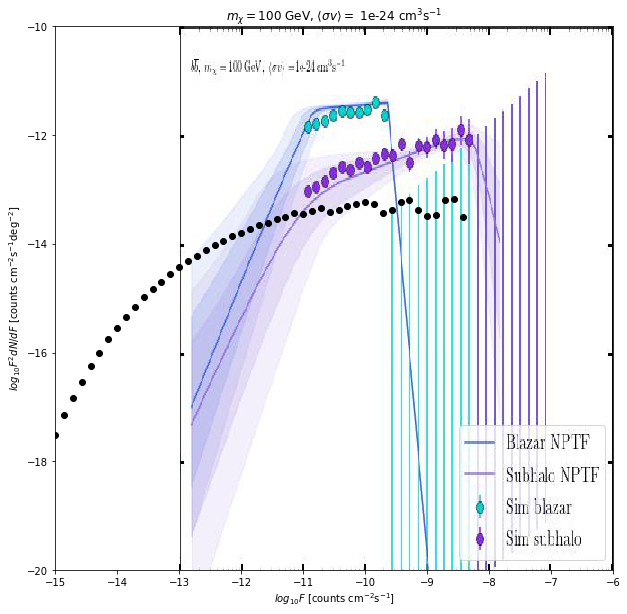

In [349]:
bins = np.logspace(-15, -6, 8*8)
min_flux_ind = np.argmin(np.abs(bins - min_flux))
min_flux_ind = 0 #temp, no flux cutoff
bins = bins[min_flux_ind:]
F_arr2 = np.array(F_arr)[:,min_flux_ind:]
F_ave = np.mean(F_arr2, axis=0)
dF = np.diff(bins)
dN = np.array(F_ave)/(4*np.pi*(180/np.pi)**2)*len(mask)/(len(mask[mask]))
F = np.array(bins)[:-1]

plt.figure(figsize=(10,10))
img = plt.imread("1e-24im.jpg")
plt.imshow(img, extent=[-13,-6,-20,-10], aspect='auto')
plt.errorbar(np.where( F!=0, np.log10(F), 0), np.where(F**2*dN/dF !=0, np.log10(F**2 * dN/dF), 0), np.zeros(len(F)), fmt='o', c="black")
plt.ylim(-20, -10)
plt.xlim(-15, -6)
plt.title("$m_{\chi} = 100$ GeV, $\\langle \sigma v \\rangle =$ "+str(xsec)+" cm$^3$s$^{-1}$")
plt.ylabel("$log_{10} F^2dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]")
plt.xlabel("$log_{10} F$ [counts cm$^{-2}$s$^{-1}$]")
plt.show()
plt.close()